Решение задачи классификации транзакций для Актионады 2025

Автор: Гурин Вячеслав Алексеевич

Задача: Построить модель для автоматического определения категории и подкатегории банковской транзакции.

Датасет: [USA Banking Transactions Dataset](https://www.kaggle.com/datasets/pradeepkumar2424/usa-banking-transactions-dataset-2023-2024?resource=download)
Метрика: Macro F1-score

План решения:

Загрузка и подготовка данных.

Комплексная инженерия признаков (NLP, даты, ручные признаки).

Решение базовой задачи (предсказание Category).

Решение усложненной задачи (предсказание Category + Subcategory).

Анализ важности признаков для финальной модели.



Шаг 1: Загрузка библиотек и данных

In [7]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

# Загрузка данных (предполагается, что файл 'Daily Transactions.csv' загружен в сессию Colab)
df = pd.read_csv('Daily Transactions.csv')
print("Данные успешно загружены. Размер:", df.shape)
df.head()

Данные успешно загружены. Размер: (2461, 8)


,Date,Mode,Category,Subcategory,Note,Amount,Income/Expense,Currency
0,20/09/2018 12:04:08,Cash,Transportation,Train,2 Place 5 to Place 0,30.0,Expense,INR
1,20/09/2018 12:03:15,Cash,Food,snacks,Idli medu Vada mix 2 plates,60.0,Expense,INR
2,19/09/2018,Saving Bank account 1,subscription,Netflix,1 month subscription,199.0,Expense,INR
3,17/09/2018 23:41:17,Saving Bank account 1,subscription,Mobile Service Provider,Data booster pack,19.0,Expense,INR
4,16/09/2018 17:15:08,Cash,Festivals,Ganesh Pujan,Ganesh idol,251.0,Expense,INR


Шаг 2: Комплексная инженерия признаков

На этом этапе мы создаем полный набор признаков, который показал наилучшие результаты в ходе исследования.

In [8]:
# --- 2.1. Базовые признаки и NLP ---
df['Note_cleaned'] = df['Note'].fillna('')
features_base = pd.get_dummies(df[['Amount', 'Mode', 'Income/Expense']])
vectorizer = TfidfVectorizer(min_df=3, max_features=100)
features_text_sparse = vectorizer.fit_transform(df['Note_cleaned'])
features_text_df = pd.DataFrame(features_text_sparse.toarray(), columns=vectorizer.get_feature_names_out())
features_advanced = pd.concat([features_base, features_text_df], axis=1)

# --- 2.2. Признаки из дат ---
df['datetime'] = pd.to_datetime(df['Date'], errors='coerce')
df['day_of_week'] = df['datetime'].dt.dayofweek
df['day_of_month'] = df['datetime'].dt.day
df['month'] = df['datetime'].dt.month
df['hour'] = df['datetime'].dt.hour
df['is_weekend'] = (df['datetime'].dt.dayofweek >= 5).astype(int)
for col in ['day_of_week', 'day_of_month', 'month', 'hour']:
    df[col].fillna(df[col].median(), inplace=True)
features_date = df[['day_of_week', 'day_of_month', 'month', 'hour', 'is_weekend']]

# --- 2.3. Ручные ("умные") признаки ---
mode_stats = df.groupby('Mode')['Amount'].agg(['mean', 'max']).rename(columns={'mean': 'mode_mean', 'max': 'mode_max'})
df_merged = df.merge(mode_stats, on='Mode', how='left')
ie_stats = df.groupby('Income/Expense')['Amount'].agg(['mean', 'max']).rename(columns={'mean': 'ie_mean', 'max': 'ie_max'})
df_merged = df_merged.merge(ie_stats, on='Income/Expense', how='left')
df_merged['amount_vs_mode_mean'] = df_merged['Amount'] / df_merged['mode_mean']
df_merged['amount_vs_mode_max'] = df_merged['Amount'] / df_merged['mode_max']
df_merged['amount_vs_ie_mean'] = df_merged['Amount'] / df_merged['ie_mean']
df_merged['amount_vs_ie_max'] = df_merged['Amount'] / df_merged['ie_max']
df_merged.fillna(0, inplace=True)
features_manual = df_merged[['amount_vs_mode_mean', 'amount_vs_mode_max', 'amount_vs_ie_mean', 'amount_vs_ie_max']]

# --- 2.4. Сборка финального набора признаков ---
features_god_tier = pd.concat([features_advanced, features_date, features_manual], axis=1)
print("Финальный набор признаков создан. Размер:", features_god_tier.shape)

Финальный набор признаков создан. Размер: (2461, 125)


/tmp/ipython-input-301155032.py:10: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['datetime'] = pd.to_datetime(df['Date'], errors='coerce')
/tmp/ipython-input-301155032.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipython-input-301155032.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a fu

Шаг 3: Решение базовой задачи (предсказание Category)

Это модель-чемпион, показавшая лучший результат на задаче предсказания основной категории.

In [9]:
X_base = features_god_tier
y_base = df['Category']

# Очистка редких классов
counts_base = y_base.value_counts()
rare_base = counts_base[counts_base < 2].index.tolist()
is_not_rare_base = ~y_base.isin(rare_base)
X_base_clean = X_base[is_not_rare_base]
y_base_clean = y_base[is_not_rare_base]

# Обучение модели
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(
    X_base_clean, y_base_clean, test_size=0.2, random_state=42, stratify=y_base_clean
)
# Добавляем параметр verbosity=-1, чтобы заткнуть модель
model_base_champion = lgb.LGBMClassifier(random_state=42, verbosity=-1)
model_base_champion.fit(X_train_base, y_train_base)

# Оценка
predictions_base = model_base_champion.predict(X_test_base)
f1_base = f1_score(y_test_base, predictions_base, average='macro')

print(f"Итоговый Macro F1-score для базовой задачи: {f1_base:.4f}\n")
print(classification_report(y_test_base, predictions_base, zero_division=0))

Итоговый Macro F1-score для базовой задачи: 0.4118

                           precision    recall  f1-score   support

                  Apparel       0.00      0.00      0.00        10
                   Beauty       0.00      0.00      0.00         4
                    Bonus       0.50      1.00      0.67         1
                     Cook       1.00      1.00      1.00         1
                  Culture       0.00      0.00      0.00         2
Dividend earned on Shares       0.67      1.00      0.80         2
                Education       0.00      0.00      0.00         4
     Equity Mutual Fund A       0.00      0.00      0.00         3
     Equity Mutual Fund C       0.00      0.00      0.00         1
     Equity Mutual Fund E       0.00      0.00      0.00         5
     Equity Mutual Fund F       0.00      0.00      0.00         3
                   Family       0.17      0.07      0.10        14
                Festivals       0.00      0.00      0.00         3
         

Шаг 4: Решение усложненной задачи (предсказание Category + Subcategory)
Это решение основной задачи, требуемой метрикой соревнования.

In [10]:
# Создание новой целевой переменной
df['Subcategory_filled'] = df['Subcategory'].fillna('Unknown')
df['Full_Category'] = df['Category'] + '_' + df['Subcategory_filled']

X_hierarchical = features_god_tier
y_hierarchical = df['Full_Category']

print(f"Количество уникальных классов в усложненной задаче: {y_hierarchical.nunique()}")

# Очистка редких классов
counts_hierarchical = y_hierarchical.value_counts()
rare_hierarchical = counts_hierarchical[counts_hierarchical < 2].index.tolist()
is_not_rare_hierarchical = ~y_hierarchical.isin(rare_hierarchical)
X_hierarchical_clean = X_hierarchical[is_not_rare_hierarchical]
y_hierarchical_clean = y_hierarchical[is_not_rare_hierarchical]

# Обучение модели
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(
    X_hierarchical_clean, y_hierarchical_clean, test_size=0.2, random_state=42, stratify=y_hierarchical_clean
)
# И сюда тоже добавляем verbosity=-1
model_hierarchical = lgb.LGBMClassifier(random_state=42, verbosity=-1)
model_hierarchical.fit(X_train_h, y_train_h)

# Оценка
predictions_h = model_hierarchical.predict(X_test_h)
f1_h = f1_score(y_test_h, predictions_h, average='macro')

print(f"\nИтоговый Macro F1-score для усложненной задачи: {f1_h:.4f}\n")
print(classification_report(y_test_h, predictions_h, zero_division=0))
print(classification_report(y_test_h, predictions_h, zero_division=0))

Количество уникальных классов в усложненной задаче: 131

Итоговый Macro F1-score для усложненной задачи: 0.3321

                                      precision    recall  f1-score   support

                    Apparel_Clothing       0.33      0.33      0.33         3
                    Apparel_Footwear       0.00      0.00      0.00         2
                     Apparel_Laundry       0.75      0.75      0.75         4
                      Beauty_Unknown       0.00      0.00      0.00         0
                     Beauty_grooming       0.00      0.00      0.00         4
                       Bonus_Unknown       1.00      1.00      1.00         1
                        Cook_Unknown       0.00      0.00      0.00         1
                       Culture_Movie       0.25      0.50      0.33         2
   Dividend earned on Shares_Unknown       0.50      0.50      0.50         2
                Education_Stationary       0.00      0.00      0.00         3
        Equity Mutual Fund A

Шаг 5: Анализ важности признаков

Анализируем модель-чемпион из базовой задачи, чтобы понять, какие признаки оказались наиболее влиятельными.

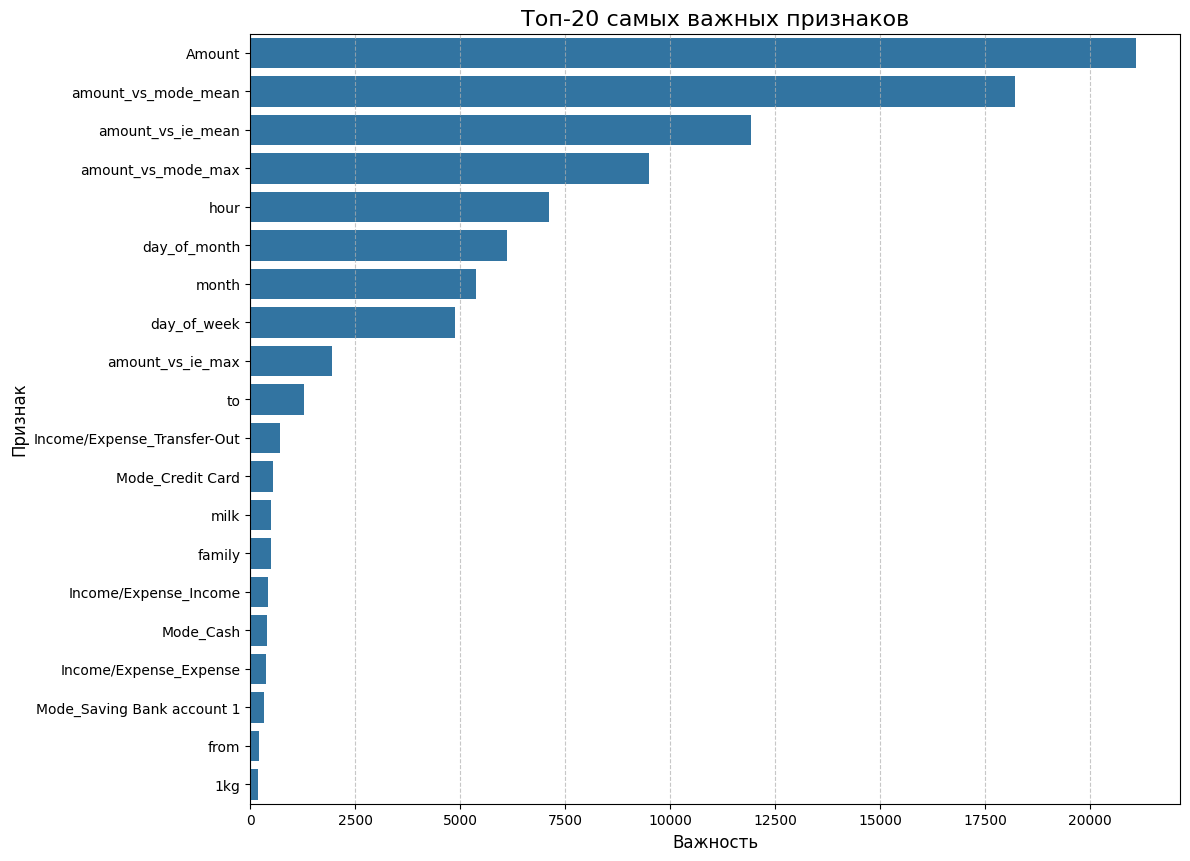

In [11]:
feature_importance_df = pd.DataFrame({
    'feature': X_base_clean.columns,
    'importance': model_base_champion.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(
    x='importance',
    y='feature',
    data=feature_importance_df.head(20)
)
plt.title('Топ-20 самых важных признаков', fontsize=16)
plt.xlabel('Важность', fontsize=12)
plt.ylabel('Признак', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()